<h1>TTPLA Detectron2 Mask R-CNN Evaluator</h1>

<p>This notebook provides a structured workflow for evaluating a trained <strong>Mask R-CNN</strong> model within the <strong>Detectron2</strong> framework on the <em>TTPLA dataset</em>. The goal is to assess the model’s effectiveness in detecting and segmenting objects in test images, using COCO evaluation metrics and additional performance parameters. This workflow includes:</p>

<ol>
    <li><strong>Loading Model Predictions and Ground Truth:</strong> Importing the model’s predictions and ground truth annotations for accurate and standardized evaluation.</li>
    <li><strong>COCO Metrics Evaluation:</strong> Utilizing the COCO evaluation tool to generate metrics such as Average Precision (AP) and Average Recall (AR) for both bounding boxes and segmentation masks, providing a comprehensive view of model performance.</li>
    <li><strong>Parsing Additional Metrics:</strong> Loading and parsing additional performance metrics from JSON files to assess detailed aspects of model behavior across various evaluation criteria.</li>
    <li><strong>Results Summary and Visualization:</strong> Summarizing and, where applicable, visualizing the evaluation metrics to offer insights into the model’s detection and segmentation quality on the TTPLA dataset.</li>
</ol>

<p>This notebook is designed to assist users in thoroughly evaluating a Mask R-CNN model’s performance on the TTPLA dataset, focusing on both object localization and instance segmentation accuracy.</p>

<h2>Installation of Libraries</h2>
<p>This cell defines the <code>Installer</code> class, which simplifies the installation of Python libraries using the <code>pip</code> package manager. It includes logging to record each installation event, covering successful installations and error details for troubleshooting.</p>

<h3>Classes</h3>
<ul>
    <li><strong>Installer</strong>: A utility class that automates the installation of Python libraries with logging support.</li>
</ul>

<h3>Usage Example</h3>
<pre><code>installer = Installer()
installer.install(['requests', 'numpy'])  # Install the specified libraries
</code></pre>

In [1]:
import subprocess
import sys
import logging

class Installer():
    def __init__(self):
        # Configure logging
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',  # Log format
            handlers=[
                logging.FileHandler('libraries.log'),  # Save logs to a file
                logging.StreamHandler(sys.stdout)  # Also print logs to the console
            ]
        )

    def _run_pip_command(self, command):
        try:
            logging.info(f"Running pip command: {command}")
            subprocess.check_call([sys.executable, "-m", "pip"] + command.split())
            logging.info(f"Command '{command}' executed successfully.")
        except subprocess.CalledProcessError as e:
            logging.error(f"Error while executing command '{command}'. Error: {e}")
            raise

    def _upgrade_pip(self):
        try:
            logging.info('Upgrading pip...')
            self._run_pip_command('install --upgrade pip')
            logging.info("pip upgraded successfully.")
        except Exception as e:
            logging.error(f"Failed to upgrade pip: {e}")
            raise

    def install(self, libraries):
        self._upgrade_pip()
        for library in libraries:
            try:
                logging.info(f"Installing library {library}...")
                self._run_pip_command(f"install {library}")
                logging.info(f"{library} installed successfully.")
            except Exception as e:
                logging.error(f"Failed to install {library}: {e}")
        logging.info('Installation of all libraries completed!')

In [2]:
libs_installer = Installer()
libs_installer.install(
    libraries=[
        'numpy',
        'tqdm',
        'gdown',
        'matplotlib',
        'torch torchvision torchaudio',
        'pycocotools',
        '-U albumentations'
    ]
)

2024-11-02 19:03:17,457 - INFO - Upgrading pip...
2024-11-02 19:03:17,458 - INFO - Running pip command: install --upgrade pip
2024-11-02 19:03:20,663 - INFO - Command 'install --upgrade pip' executed successfully.
2024-11-02 19:03:20,663 - INFO - pip upgraded successfully.
2024-11-02 19:03:20,664 - INFO - Installing library numpy...
2024-11-02 19:03:20,665 - INFO - Running pip command: install numpy
2024-11-02 19:03:23,775 - INFO - Command 'install numpy' executed successfully.
2024-11-02 19:03:23,776 - INFO - numpy installed successfully.
2024-11-02 19:03:23,777 - INFO - Installing library tqdm...
2024-11-02 19:03:23,778 - INFO - Running pip command: install tqdm
2024-11-02 19:03:26,611 - INFO - Command 'install tqdm' executed successfully.
2024-11-02 19:03:26,613 - INFO - tqdm installed successfully.
2024-11-02 19:03:26,614 - INFO - Installing library gdown...
2024-11-02 19:03:26,616 - INFO - Running pip command: install gdown
2024-11-02 19:03:29,420 - INFO - Command 'install gdown' 

In [3]:
import os
import numpy as np
import json
import shutil
import gdown
import datetime
import random
import re

import torch
import albumentations as A
import pycocotools
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

from tqdm import tqdm
import contextlib
import textwrap

from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib import collections
import matplotlib.colors as mcolors
import cv2

from pprint import pprint
class ptype:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def gprint(content):
    print(
        ptype.BLUE + 
        ptype.BOLD + 
        '{}'.format(content) + 
        ptype.END
    )

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 4090
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


<h1>Preparing Input Directory and the TTPLA Dataset</h1>
<ul>
    <li>We define the path for an input directory, <code>in_data_dir</code>, and create this folder if it doesn’t already exist. This step is essential to organize the necessary input files (trainingset and testset) for the project.</li>
    <li>Inside the input folder, we create another folder named <code>in_dataset_name</code> (<code>ttpla-dataset</code>), where the dataset files will be stored.</li>
    <li>We download the <code>TTPLA</code> dataset from Google Drive using a direct file link (<code>url_dataset</code>) and the <code>gdown</code> module, saving it as a ZIP archive in the dataset directory.</li>
    <li>After downloading, we extract the contents of the ZIP file into the dataset directory and then delete the ZIP file to save disk space.</li>
</ul>

In [4]:
in_data_dir = './input/'
if not os.path.exists(in_data_dir):
    os.makedirs(in_data_dir)
in_dataset_name = 'ttpla-dataset'
in_dataset_path = os.path.join(in_data_dir, in_dataset_name)
if not os.path.exists(in_dataset_path):
    os.makedirs(in_dataset_path)

id_dataset = '1t4ZCts89QfMgsqhJq9Jkmm-VofpgeWCT'
url_dataset = 'https://drive.google.com/uc?id={}'.format(id_dataset)
ftype = 'zip'
dataset_zip_path = os.path.join(in_dataset_path, '{}.{}'.format(in_dataset_name, ftype))
gdown.download(url_dataset, dataset_zip_path, quiet=False, fuzzy=True)
shutil.unpack_archive(dataset_zip_path, in_dataset_path, ftype)  
os.remove(dataset_zip_path)

gprint('TTPLA dataset path')
pprint(in_dataset_path)
print('-'*40)
gprint('TTPLA dataset files list')
pprint(os.listdir(in_dataset_path))

out_data_dir = './working/'
models_name = 'models/ttpla'
models_path = os.path.join(out_data_dir, models_name)
if not os.path.exists(models_path):
    os.makedirs(models_path)

id_model = '1wb6ttjP_-1OEZaCvk0aBWIYVlt_U3fIH'
url_model = 'https://drive.google.com/uc?id={}'.format(id_model)
ftype = 'zip'
model_zip_name = 'ttpla'
model_zip_path = os.path.join(models_path, '{}.{}'.format(model_zip_name, ftype))
gdown.download(url_model, model_zip_path, quiet=False, fuzzy=True)
shutil.unpack_archive(model_zip_path, models_path, ftype)  
os.remove(model_zip_path)

model_name = 'model_final.pth'
model_path = os.path.join(models_path, model_name)
gprint('Model path')
print(model_path)

Downloading...
From (original): https://drive.google.com/uc?id=1t4ZCts89QfMgsqhJq9Jkmm-VofpgeWCT
From (redirected): https://drive.google.com/uc?id=1t4ZCts89QfMgsqhJq9Jkmm-VofpgeWCT&confirm=t&uuid=a865b079-6c69-43a2-bb2b-8c869b39aaf8
To: D:\virtualenv\src\cv-project\input\ttpla-dataset\ttpla-dataset.zip
100%|███████████████████████████████████████████████████████████████████████████████| 291M/291M [02:39<00:00, 1.83MB/s]


TTPLA dataset path
'./input/ttpla-dataset'
----------------------------------------
TTPLA dataset files list
['testset', 'trainingset']


Downloading...
From (original): https://drive.google.com/uc?id=1wb6ttjP_-1OEZaCvk0aBWIYVlt_U3fIH
From (redirected): https://drive.google.com/uc?id=1wb6ttjP_-1OEZaCvk0aBWIYVlt_U3fIH&confirm=t&uuid=6ec4cf21-392c-409d-a2b6-02f2de1e3c15
To: D:\virtualenv\src\cv-project\working\models\ttpla\ttpla.zip
100%|███████████████████████████████████████████████████████████████████████████████| 804M/804M [06:23<00:00, 2.09MB/s]


Model path
./working/models/ttpla\model_final.pth


In [5]:
"""
This cell provides utility functions for displaying file lists in a readable, side-by-side format
and for truncating long lists of files for concise output.

Functions:
    print_side_by_side_column(name, files): Displays a list of files in a single column format with a header.
    get_file_list(files, num=5): Returns a shortened list of files.

Variables:
    num_toshow (int): The default number of files to show in a truncated list, used by `get_file_list`.
"""

num_toshow = 5

def print_side_by_side_column(name, files):
    max_len = len(files)
    col_width = 30

    gprint(f"{name:<{col_width}}")

    for i in range(max_len):
        file = f"  - {files[i]}" if i < len(files) else " " * col_width
        print(f"{file:<{col_width}}")

def get_file_list(files, num=5):
    if len(files) > num+1:
        return files[:num] + ['...'] + [files[-1]]
    return files

<h1>Evaluation</h1>

In [6]:
testset_name = 'testset'
testset_path = os.path.join(in_dataset_path, testset_name)
gprint('Testset path')
print('{}'.format(testset_path))

testset_anns_name = 'test.json'
testset_anns_path = os.path.join(testset_path, testset_anns_name)
gprint('Testset annotations path')
print('{}'.format(testset_anns_path))

testset_files_list = os.listdir(testset_path)
testset_display = get_file_list(files=testset_files_list, num=num_toshow)
len(testset_files_list),
print_side_by_side_column(
    name="Testset files",
    files=testset_display
)

Testset path
./input/ttpla-dataset\testset
Testset annotations path
./input/ttpla-dataset\testset\test.json
Testset files                 
  - 04_2220.jpg               
  - 04_3420.jpg               
  - 08_1725.jpg               
  - 1000_00273.jpg            
  - 1000_00285.jpg            
  - ...                       
  - test.json                 


<h2>Model Evaluation with COCO Metrics</h2>

<p>This cell evaluates the performance of the Mask R-CNN model on the test dataset using <strong>COCO evaluation metrics</strong>. The evaluation process is split into two types: <em>bounding box (bbox)</em> and <em>segmentation (segm)</em>. The steps include:</p>

<ol>
    <li><strong>Loading Ground Truth Annotations:</strong> The ground truth annotations for the test set are loaded using the COCO format, providing reference data against which predictions will be compared.</li>
    <li><strong>Loading Model Predictions:</strong> The model's predictions, saved in the COCO format (as <code>coco_instances_results.json</code>), are loaded to allow for a standardized evaluation.</li>
    <li><strong>Bounding Box Evaluation:</strong> The COCO evaluation tool calculates metrics such as Average Precision (AP) and Average Recall (AR) for bounding box predictions, followed by accumulation and summary of results.</li>
    <li><strong>Segmentation Evaluation:</strong> A similar process is repeated for segmentation masks, allowing the COCO tool to evaluate segmentation accuracy in terms of AP and AR for mask predictions.</li>
</ol>

<p>This cell provides a comprehensive summary of the model’s performance on the test set, helping to assess its accuracy in both object localization (bbox) and instance segmentation (segm). The <code>COCOeval</code> tool outputs detailed metrics that give insight into the effectiveness of the model's predictions.</p>


In [7]:
gt = COCO(testset_anns_path)

predictions_name = 'coco_instances_results.json'
predictions_path = os.path.join(models_path, predictions_name)
predictions = gt.loadRes(predictions_path)

annType = 'bbox'
cocoEval_bbox = COCOeval(gt, predictions, annType)
cocoEval_bbox.evaluate()
cocoEval_bbox.accumulate()
cocoEval_bbox.summarize()

annType = 'segm'
cocoEval_segm = COCOeval(gt, predictions, annType)
cocoEval_segm.evaluate()
cocoEval_segm.accumulate()
cocoEval_segm.summarize()

loading annotations into memory...
Done (t=0.15s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.27s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.88s).
Accumulating evaluation results...
DONE (t=0.46s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.475
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.688
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.495
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.268
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.475
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.545
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.366
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.569
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [8]:
old_predictions_path = predictions_path
new_predictions_name = '247284_242530.json'
new_predictions_path = os.path.join(models_path, new_predictions_name)
os.rename(old_predictions_path, new_predictions_path)
gprint('Predictions path')
print('{}'.format(new_predictions_path))

Predictions path
./working/models/ttpla\247284_242530.json


<h2>Parsing and Loading Model Metrics</h2>

<p>This cell reads and parses a JSON file (<code>metrics.json</code>) containing performance metrics collected during model training.

<ol>
    <li><strong>Define Path to Metrics File:</strong> The path to the <code>metrics.json</code> file is set, allowing access to previously recorded model performance metrics.</li>
    <li><strong>Initialize Parsing:</strong> An empty list, <code>metrics</code>, is prepared to store parsed JSON data, and a regex pattern is defined to detect the start of each new JSON block within the file.</li>
    <li><strong>Iterate through File Lines:</strong> The file is read line by line. Each time a new JSON object is detected (matching the regex pattern), the previous block is added to the <code>metrics</code> list after attempting to parse it as JSON.</li>
    <li><strong>Parse Remaining Data:</strong> After reaching the end of the file, any remaining JSON block is parsed and added to the <code>metrics</code> list, ensuring no data is missed.</li>
</ol>

<p>This approach handles cases where multiple JSON entries are saved in a single file, allowing for flexible loading of complex metrics data.</p>

In [9]:
metrics_name = 'metrics.json'
metrics_path = os.path.join(models_path, metrics_name)

metrics = []
json_start_pattern = re.compile(r'^\{')
current_block = ""
with open(metrics_path, 'r') as file:
    for line in file:
        if json_start_pattern.match(line):
            if current_block:
                try:
                    metrics.append(json.loads(current_block))
                except json.JSONDecodeError:
                    pass
            current_block = line
        else:
            current_block += line

if current_block:
    try:
        metrics.append(json.loads(current_block))
    except json.JSONDecodeError:
        pass

len(metrics), metrics[:1]

(500,
 [{'data_time': 0.019743707962334156,
   'eta_seconds': 8835.916312579066,
   'fast_rcnn/cls_accuracy': 0.8466796875,
   'fast_rcnn/false_negative': 1.0,
   'fast_rcnn/fg_cls_accuracy': 0.0,
   'iteration': 19,
   'loss_box_reg': 0.42403268814086914,
   'loss_cls': 1.0331857204437256,
   'loss_mask': 0.588363915681839,
   'loss_rpn_cls': 0.5819352865219116,
   'loss_rpn_loc': 0.37931403517723083,
   'lr': 0.0002881,
   'mask_rcnn/accuracy': 0.9274180995927783,
   'mask_rcnn/false_negative': 0.993356681544067,
   'mask_rcnn/false_positive': 0.00010214982817091208,
   'rank_data_time': 0.019743707962334156,
   'roi_head/num_bg_samples': 225.4375,
   'roi_head/num_fg_samples': 30.5625,
   'rpn/num_neg_anchors': 178.75,
   'rpn/num_pos_anchors': 77.25,
   'time': 0.8853623559698462,
   'total_loss': 3.1121006309986115}])

In [10]:
entry = metrics[0]
entry_keys = entry.keys()
gprint('Entry Metrics Keys')
pprint(entry_keys)

Entry Metrics Keys
dict_keys(['data_time', 'eta_seconds', 'fast_rcnn/cls_accuracy', 'fast_rcnn/false_negative', 'fast_rcnn/fg_cls_accuracy', 'iteration', 'loss_box_reg', 'loss_cls', 'loss_mask', 'loss_rpn_cls', 'loss_rpn_loc', 'lr', 'mask_rcnn/accuracy', 'mask_rcnn/false_negative', 'mask_rcnn/false_positive', 'rank_data_time', 'roi_head/num_bg_samples', 'roi_head/num_fg_samples', 'rpn/num_neg_anchors', 'rpn/num_pos_anchors', 'time', 'total_loss'])


In [11]:
iterations = [entry["iteration"] for entry in metrics]
time = [entry["time"] for entry in metrics]

fast_rcnn_cls_accuracy = [entry["fast_rcnn/cls_accuracy"] for entry in metrics]
fast_rcnn_fg_cls_accuracy = [entry["fast_rcnn/fg_cls_accuracy"] for entry in metrics]
mask_rcnn_accuracy = [entry["mask_rcnn/accuracy"] for entry in metrics]

fast_rcnn_false_negative = [entry["fast_rcnn/false_negative"] for entry in metrics]
mask_rcnn_false_negative = [entry["mask_rcnn/false_negative"] for entry in metrics]
mask_rcnn_false_positive = [entry["mask_rcnn/false_positive"] for entry in metrics]

loss_box_reg = [entry["loss_box_reg"] for entry in metrics]
loss_cls = [entry["loss_cls"] for entry in metrics]
loss_mask = [entry["loss_mask"] for entry in metrics]
loss_rpn_cls = [entry["loss_rpn_cls"] for entry in metrics]
loss_rpn_loc = [entry["loss_rpn_loc"] for entry in metrics]
total_loss = [entry["total_loss"] for entry in metrics]

<h1>Accuracy over Iterations</h1>

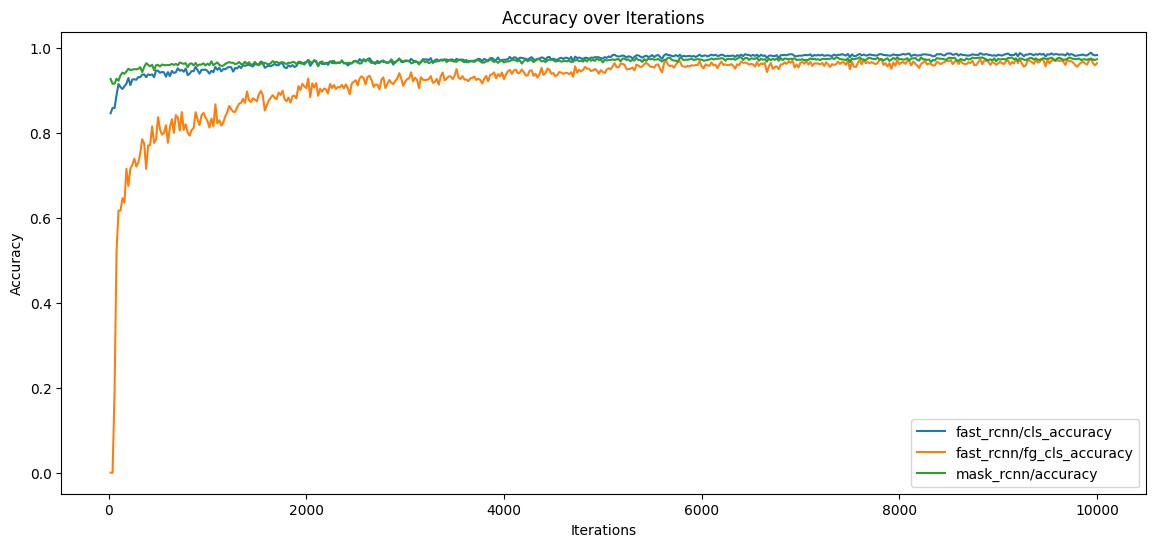

fast_rcnn/cls_accuracy
0.983642578125
fast_rcnn/fg_cls_accuracy
0.9647003231510274
mask_rcnn/accuracy
0.973946904302919


In [15]:
plt.figure(figsize=(14,6))
plt.plot(iterations, fast_rcnn_cls_accuracy, label='fast_rcnn/cls_accuracy')
plt.plot(iterations, fast_rcnn_fg_cls_accuracy, label='fast_rcnn/fg_cls_accuracy')
plt.plot(iterations, mask_rcnn_accuracy, label='mask_rcnn/accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Iterations')
accuracyfig_name = 'accuracy.jpg'
accuracyfig_path = os.path.join(models_path, accuracyfig_name)
plt.savefig(accuracyfig_path)
plt.show()

gprint('fast_rcnn/cls_accuracy')
pprint(fast_rcnn_cls_accuracy[-1])  
gprint('fast_rcnn/fg_cls_accuracy')
pprint(fast_rcnn_fg_cls_accuracy[-1])
gprint('mask_rcnn/accuracy')
pprint(mask_rcnn_accuracy[-1])

<h1>False Negative/Positive over Iterations</h1>

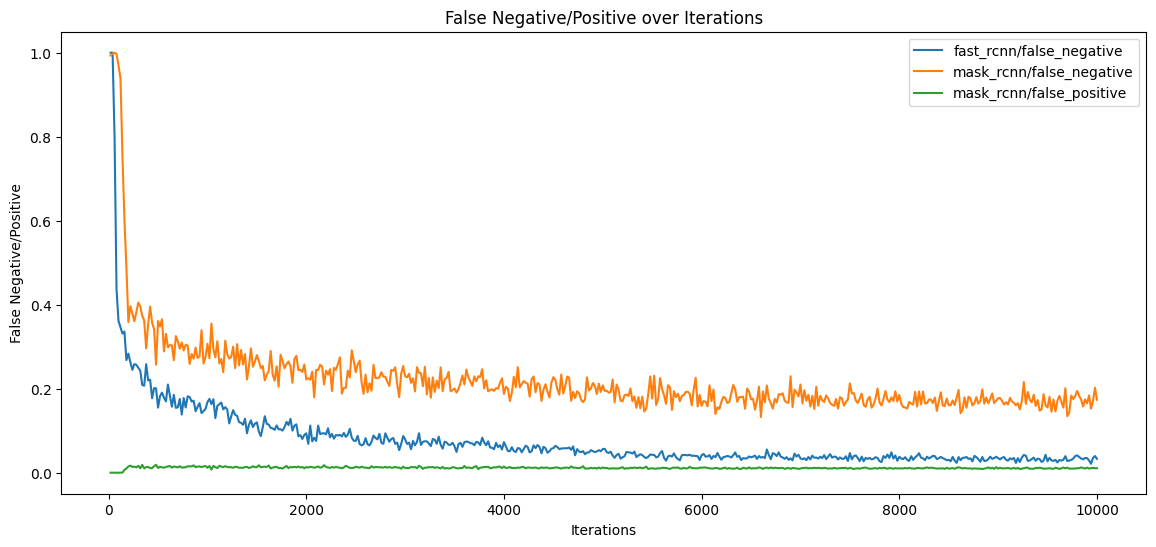

fast_rcnn/false_negative
0.03306769020590053
mask_rcnn/false_negative
0.17378435934435807
mask_rcnn/false_positive
0.010656863235044814


In [16]:
plt.figure(figsize=(14,6))
plt.plot(iterations, fast_rcnn_false_negative, label='fast_rcnn/false_negative')
plt.plot(iterations, mask_rcnn_false_negative, label='mask_rcnn/false_negative')
plt.plot(iterations, mask_rcnn_false_positive, label='mask_rcnn/false_positive')
plt.xlabel('Iterations')
plt.ylabel('False Negative/Positive')
plt.legend()
plt.title('False Negative/Positive over Iterations')
falsefig_name = 'false.jpg'
falsefig_path = os.path.join(models_path, falsefig_name)
plt.savefig(falsefig_path)
plt.show()

gprint('fast_rcnn/false_negative')
pprint(fast_rcnn_false_negative[-1])  
gprint('mask_rcnn/false_negative')
pprint(mask_rcnn_false_negative[-1])
gprint('mask_rcnn/false_positive')
pprint(mask_rcnn_false_positive[-1])

<h1>Loss over Iterations</h1>

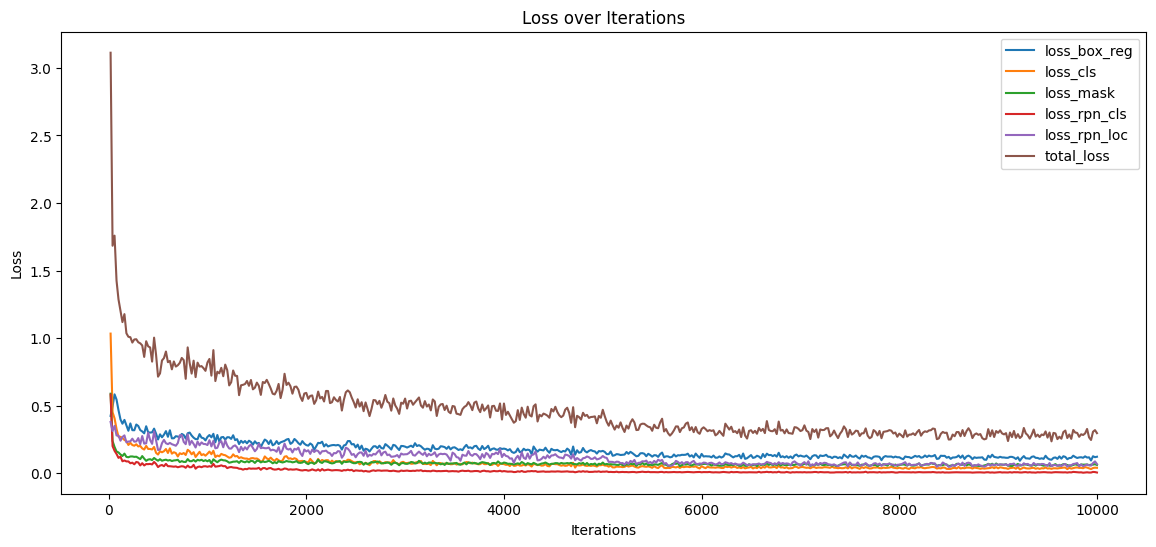

loss_box_reg
0.12180643901228905
loss_cls
0.0399143360555172
loss_mask
0.06077864579856396
loss_rpn_cls
0.005034257657825947
loss_rpn_loc
0.06778925657272339
total_loss
0.29653332216548733


In [17]:
plt.figure(figsize=(14,6))
plt.plot(iterations, loss_box_reg, label='loss_box_reg')
plt.plot(iterations, loss_cls, label='loss_cls')
plt.plot(iterations, loss_mask, label='loss_mask')
plt.plot(iterations, loss_rpn_cls, label='loss_rpn_cls')
plt.plot(iterations, loss_rpn_loc, label='loss_rpn_loc')
plt.plot(iterations, total_loss, label='total_loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Iterations')
lossfig_name = 'loss.jpg'
lossfig_path = os.path.join(models_path, lossfig_name)
plt.savefig(lossfig_path)
plt.show()

gprint('loss_box_reg')
pprint(loss_box_reg[-1])  
gprint('loss_cls')
pprint(loss_cls[-1])
gprint('loss_mask')
pprint(loss_mask[-1])
gprint('loss_rpn_cls')
pprint(loss_rpn_cls[-1])
gprint('loss_rpn_loc')
pprint(loss_rpn_loc[-1])
gprint('total_loss')
pprint(total_loss[-1])